# 🤖 Robot Odometry & Event Analysis

Clean, minimal analysis of robot trajectory and experiment feedback events.

### Actual Data Sources
- **Odometry** (`/robomaster/odom`): position (x, y), orientation quaternion (converted to yaw), linear velocities (vx, vy), angular velocity (wz). Yaw (deg) and planar speed are derived here.
- **Experiment Events** (`/experiment/event`): JSON messages (via `std_msgs/String`) containing `event_type`, `action`, `details`, etc.
- **Fallback Events** (if topic missing): Matching `.jsonl` file in `experiment_logs/` whose filename corresponds to the bag directory name.

### Derived Columns & Structures
- `time_rel`: seconds since first odometry sample
- `yaw_deg`: yaw in degrees derived from odometry quaternion
- `speed`: √(vx² + vy²)
- `event_positions`: each relevant event mapped to nearest odometry pose (≤1 s difference)

### Outputs
- Static trajectory plots (with and without event overlays)
- Speed and heading statistics
- Filtered interactive trajectory explorer (dual-handle time slider) highlighting ONLY good / bad feedback events

### Feedback Event Filtering Logic (Interactive Plot)
Shown markers include only:
- `positive_feedback`
- `feedback_blink` with details containing *good* or *bad*
- Any action whose name contains *negative* or *bad*

### Next Extensions (optional)
- Smarter downsampling (RDP/event-aware)
- Export selected window stats

---
Run the cells below after setting `BAG_FILE` to your experiment bag directory.

In [34]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# ROS2 bag reading with rosbags library (pure Python, no ROS required)
try:
    from rosbags.rosbag2 import Reader
    from rosbags.serde import deserialize_cdr
    print("rosbags library loaded (pure Python)")
except ImportError:
    print("rosbags library not found!")
    print("Install with: pip install rosbags")

# Configure plotting
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['font.size'] = 11
plt.style.use('default')

print("Ready for odometry analysis!")

rosbags library loaded (pure Python)
Ready for odometry analysis!


In [35]:
# Configuration - Update your bag file path
BAG_FILE = "experiment_bags/exp_pregassona_1_2025-09-13T07-16-09-907Z"
# BAG_FILE = "experiment_bags/exp_pregassona_2_2025-09-13T07-36-14-321Z"

# Verify bag exists
if os.path.exists(BAG_FILE):
    print(f"Bag found: {BAG_FILE}")
else:
    print(f"Bag not found: {BAG_FILE}")
    print("Update BAG_FILE path above")

print("\nExpected topics:")
print("   • /robomaster/odom (odometry data)")
print("   • /robomaster/imu (orientation)")

Bag found: experiment_bags/exp_pregassona_1_2025-09-13T07-16-09-907Z

Expected topics:
   • /robomaster/odom (odometry data)
   • /robomaster/imu (orientation)


In [36]:
# Read odometry data from bag
def read_odometry_data(bag_path):
    """Extract odometry data from ROS2 bag using rosbags library"""
    if not os.path.exists(bag_path):
        return []
    
    odom_data = []
    
    try:
        with Reader(bag_path) as reader:
            # Filter for odometry topic
            connections = [x for x in reader.connections if x.topic == '/robomaster/odom']
            
            if not connections:
                print("No /robomaster/odom topic found in bag")
                return []
            
            for connection, timestamp, rawdata in reader.messages(connections=connections):
                # Deserialize the message
                odom_msg = deserialize_cdr(rawdata, connection.msgtype)
                
                # Extract position
                x = odom_msg.pose.pose.position.x
                y = odom_msg.pose.pose.position.y
                
                # Extract orientation (quaternion to yaw)
                qx = odom_msg.pose.pose.orientation.x
                qy = odom_msg.pose.pose.orientation.y
                qz = odom_msg.pose.pose.orientation.z
                qw = odom_msg.pose.pose.orientation.w
                yaw = np.arctan2(2.0 * (qw * qz + qx * qy), 1.0 - 2.0 * (qy * qy + qz * qz))
                
                # Extract velocities
                vx = odom_msg.twist.twist.linear.x
                vy = odom_msg.twist.twist.linear.y
                wz = odom_msg.twist.twist.angular.z
                
                odom_data.append({
                    'timestamp': timestamp / 1e9,  # Convert nanoseconds to seconds
                    'x': x,
                    'y': y,
                    'yaw': yaw,
                    'yaw_deg': np.degrees(yaw),
                    'vx': vx,
                    'vy': vy,
                    'wz': wz,
                    'speed': np.sqrt(vx*vx + vy*vy)
                })
                
    except Exception as e:
        print(f"Error reading odometry: {e}")
        return []
    
    print(f"Read {len(odom_data)} odometry points")
    return odom_data

print("Odometry reader ready")

Odometry reader ready


In [37]:
# Read event data from bag
def read_event_data(bag_path):
    """Extract event data from ROS2 bag using rosbags library"""
    if not os.path.exists(bag_path):
        return []
    
    event_data = []
    
    try:
        with Reader(bag_path) as reader:
            # Filter for experiment event topic
            connections = [x for x in reader.connections if x.topic == '/experiment/event']
            
            if not connections:
                print("No /experiment/event topic found in bag")
                return []
            
            for connection, timestamp, rawdata in reader.messages(connections=connections):
                try:
                    # Deserialize the message
                    event_msg = deserialize_cdr(rawdata, connection.msgtype)
                    
                    # Parse event message (assuming it's a JSON string in std_msgs/String)
                    if hasattr(event_msg, 'data'):
                        import json
                        try:
                            event_json = json.loads(event_msg.data)
                            event_data.append({
                                'timestamp': timestamp / 1e9,  # Convert nanoseconds to seconds
                                'event_type': event_json.get('event_type', 'unknown'),
                                'action': event_json.get('action', 'unknown'),
                                'details': event_json.get('details', {}),
                                'session_id': event_json.get('session_id', '')
                            })
                        except json.JSONDecodeError:
                            # If not JSON, treat as plain string
                            event_data.append({
                                'timestamp': timestamp / 1e9,
                                'event_type': 'raw_message',
                                'action': 'message',
                                'details': {'message': event_msg.data},
                                'session_id': ''
                            })
                            
                except Exception as e:
                    print(f"Error parsing event message: {e}")
                    continue
                
    except Exception as e:
        print(f"Error reading events: {e}")
        return []
    
    print(f"Read {len(event_data)} event messages")
    return event_data

# Alternative: Read from JSONL file if bag reading fails
def read_event_data_from_jsonl(bag_path):
    """Fallback: read events from JSONL file"""
    import json
    from pathlib import Path
    
    # Try to find matching JSONL file
    bag_name = Path(bag_path).name
    jsonl_path = Path(bag_path).parent.parent / "experiment_logs" / f"{bag_name}.jsonl"
    
    if not jsonl_path.exists():
        print(f"No JSONL file found at: {jsonl_path}")
        return []
    
    event_data = []
    try:
        with open(jsonl_path, 'r') as f:
            for line in f:
                if line.strip():
                    event_json = json.loads(line.strip())
                    # Convert ISO timestamp to Unix timestamp
                    from datetime import datetime
                    iso_time = event_json.get('timestamp', '')
                    unix_time = datetime.fromisoformat(iso_time.replace('Z', '+00:00')).timestamp()
                    
                    event_data.append({
                        'timestamp': unix_time,
                        'event_type': event_json.get('event_type', 'unknown'),
                        'action': event_json.get('action', 'unknown'),
                        'details': event_json.get('details', {}),
                        'session_id': event_json.get('session_id', '')
                    })
    except Exception as e:
        print(f"Error reading JSONL: {e}")
        return []
        
    print(f"Read {len(event_data)} events from JSONL file")
    return event_data

print("Event data readers ready")

Event data readers ready


In [38]:
# Load and analyze odometry data
print("Loading odometry data...")

odom_data = read_odometry_data(BAG_FILE)

if not odom_data:
    print("No odometry data found!")
    print("Make sure /robomaster/odom is in your bag file")
else:
    # Convert to DataFrame
    df = pd.DataFrame(odom_data)
    df['time'] = pd.to_datetime(df['timestamp'], unit='s')
    df['time_rel'] = df['timestamp'] - df['timestamp'].iloc[0]
    
    # Calculate trajectory metrics
    duration = df['time_rel'].iloc[-1]
    
    # Calculate distance traveled
    distances = []
    for i in range(1, len(df)):
        dx = df['x'].iloc[i] - df['x'].iloc[i-1]
        dy = df['y'].iloc[i] - df['y'].iloc[i-1]
        distances.append(np.sqrt(dx*dx + dy*dy))
    total_distance = sum(distances)
    
    # Summary statistics
    print(f"\nTRAJECTORY SUMMARY:")
    print(f"   Duration: {duration:.1f} seconds")
    print(f"   Data points: {len(df)}")
    print(f"   Total distance: {total_distance:.2f} meters")
    print(f"   X range: {df['x'].min(): .2f} to {df['x'].max(): .2f} m")
    print(f"   Y range: {df['y'].min(): .2f} to {df['y'].max(): .2f} m")
    print(f"   Heading range: {df['yaw_deg'].min(): .0f}° to {df['yaw_deg'].max(): .0f}°")
    print(f"   Max speed: {df['speed'].max(): .2f} m/s")
    print(f"   Avg speed: {df['speed'].mean(): .2f} m/s")

    print(f"\nFirst few data points:")
    print(df[['time_rel', 'x', 'y', 'yaw_deg', 'speed']].head())

Loading odometry data...
Read 10358 odometry points


/var/folders/98/v8ztsv9j68jbywz9_nz00_4m0000gn/T/ipykernel_74697/3606843681.py:20: DeprecationWarning:

Global serialization/deserialization functions have been replaced with
explicit typestores.

If you are deserializing messages from an AnyReader instance, simply
use its `.deserialize(data, typename)` method.

Otherwise instantiate a type store and use its methods:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.deserialize_cdr(data, typename)




TRAJECTORY SUMMARY:
   Duration: 1055.6 seconds
   Data points: 10358
   Total distance: 73.68 meters
   X range: -4.53 to  0.22 m
   Y range:  1.23 to  4.92 m
   Heading range: -180° to  180°
   Max speed:  0.84 m/s
   Avg speed:  0.12 m/s

First few data points:
   time_rel        x        y  yaw_deg     speed
0  0.000000 -1.99681  1.25982    70.13  0.014142
1  0.101629 -1.99677  1.25990    70.17  0.014142
2  0.200319 -1.99727  1.26010    70.11  0.014142
3  0.301509 -1.99706  1.26022    70.11  0.014142
4  0.401840 -1.99732  1.26051    70.15  0.014142


In [39]:
# Load and analyze event data
print("Loading event data...")

# Try reading from ROS2 bag first, then fallback to JSONL
event_data = read_event_data(BAG_FILE)
if not event_data:
    print("No events from bag, trying JSONL file...")
    event_data = read_event_data_from_jsonl(BAG_FILE)

if not event_data:
    print("No event data found!")
    events_df = pd.DataFrame()  # Empty dataframe
else:
    # Convert to DataFrame
    events_df = pd.DataFrame(event_data)
    
    # Align timestamps with odometry (relative to start)
    if 'df' in locals() and not df.empty:
        odom_start_time = df['timestamp'].iloc[0]
        events_df['time_rel'] = events_df['timestamp'] - odom_start_time
        
        # Filter events to trajectory timespan
        trajectory_end = df['timestamp'].iloc[-1]
        events_df = events_df[
            (events_df['timestamp'] >= odom_start_time) & 
            (events_df['timestamp'] <= trajectory_end)
        ].copy()
    else:
        events_df['time_rel'] = events_df['timestamp'] - events_df['timestamp'].iloc[0]
    
    # Categorize events by type for visualization
    feedback_events = events_df[events_df['event_type'] == 'system'].copy()
    led_events = events_df[events_df['event_type'] == 'led_control'].copy()
    sound_events = events_df[events_df['event_type'] == 'sound_control'].copy()
    movement_events = events_df[events_df['event_type'] == 'movement'].copy()

    # Arm events: either arm_control or movement events with action_name '/robomaster/move_arm_pose'
    # arm events could be in 'movement' since it was missclassified by the ros-server publisher
    arm_events = events_df[(events_df['event_type'] == 'arm_control') | 
                           ((events_df['event_type'] == 'movement') & 
                            (events_df['details'].apply(lambda d: isinstance(d, dict) and d.get('action_name') == '/robomaster/move_arm_pose')))
                          ].copy()
    
    # Identify box open (pose_type=4) and box close (pose_type=2) events
    def _pose_type(ev_details):
        if isinstance(ev_details, dict):
            return ev_details.get('goal', {}).get('pose_type')
        return None
    arm_events['pose_type'] = arm_events['details'].apply(_pose_type)
    open_box_events = arm_events[arm_events['pose_type'] == 4].copy()
    close_box_events = arm_events[arm_events['pose_type'] == 2].copy()

    print(f"   Box opening events (pose_type=4): {len(open_box_events)}")
    print(f"   Box closing events (pose_type=2): {len(close_box_events)}")

    # Summary statistics
    print(f"\nEVENT SUMMARY:")
    print(f"   Total events: {len(events_df)}")
    print(f"   System feedback: {len(feedback_events)}")
    print(f"   LED controls: {len(led_events)}")
    print(f"   Sound events: {len(sound_events)}")
    print(f"   Movement events: {len(movement_events)}")
    print(f"   Arm events: {len(arm_events)}")

    # Show interesting events
    positive_feedback = events_df[events_df['action'] == 'positive_feedback']
    if len(positive_feedback) > 0:
        print(f"   Positive feedback events: {len(positive_feedback)}")
        print(f"      Times: {positive_feedback['time_rel'].round(1).tolist()[:5]} seconds")
    
    negative_feedback = events_df[events_df['action'].str.contains('negative|bad', na=False)]
    if len(negative_feedback) > 0:
        print(f"   Negative feedback events: {len(negative_feedback)}")
    
    print(f"\n📋 Event types found:")
    print(events_df['action'].value_counts().head(10))

Loading event data...
Read 1783 event messages
   Box opening events (pose_type=4): 60
   Box closing events (pose_type=2): 58

EVENT SUMMARY:
   Total events: 1783
   System feedback: 0
   LED controls: 220
   Sound events: 0
   Movement events: 1563
   Arm events: 118

📋 Event types found:
action
joystick_move               745
joystick_start              350
joystick_end                350
set_color                   200
generic_action               59
generic_action_completed     59
feedback_blink               20
Name: count, dtype: int64


/var/folders/98/v8ztsv9j68jbywz9_nz00_4m0000gn/T/ipykernel_74697/1532021912.py:21: DeprecationWarning:

Global serialization/deserialization functions have been replaced with
explicit typestores.

If you are deserializing messages from an AnyReader instance, simply
use its `.deserialize(data, typename)` method.

Otherwise instantiate a type store and use its methods:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.deserialize_cdr(data, typename)



In [40]:
# Function to find robot position at event times
def get_robot_position_at_events(odom_df, events_df):
    """Find robot position when each event occurred"""
    event_positions = []
    
    for _, event in events_df.iterrows():
        event_time = event['timestamp']
        
        # Find closest odometry point
        time_diffs = np.abs(odom_df['timestamp'] - event_time)
        closest_idx = time_diffs.idxmin()
        
        if time_diffs.iloc[closest_idx] < 1.0:  # Within 1 second
            robot_pos = {
                'event_time': event['time_rel'],
                'event_type': event['event_type'],
                'action': event['action'],
                'x': odom_df.loc[closest_idx, 'x'],
                'y': odom_df.loc[closest_idx, 'y'],
                'yaw': odom_df.loc[closest_idx, 'yaw'],
                'details': event.get('details', {})
            }
            event_positions.append(robot_pos)
    
    return pd.DataFrame(event_positions)

# Get event positions
if 'df' in locals() and 'events_df' in locals() and not events_df.empty:
    event_positions = get_robot_position_at_events(df, events_df)
    print(f"Mapped {len(event_positions)} events to robot positions")
    
    if len(event_positions) > 0:
        print(f"\nEvents on trajectory:")
        for event_type in event_positions['event_type'].unique():
            count = len(event_positions[event_positions['event_type'] == event_type])
            print(f"   • {event_type}: {count} events")
else:
    event_positions = pd.DataFrame()
    print("No events to map to positions")

Mapped 1783 events to robot positions

Events on trajectory:
   • movement: 1563 events
   • led_control: 220 events


In [41]:
# Detailed Speed Analysis
def analyze_robot_speed_patterns(odom_df, events_df=None, event_positions=None):
    """Analyze robot speed patterns and correlate with events"""
    
    if odom_df.empty:
        print("No odometry data available for speed analysis")
        return
    
    # Calculate speed statistics
    speed_stats = {
        'mean_speed': odom_df['speed'].mean(),
        'max_speed': odom_df['speed'].max(),
        'min_speed': odom_df['speed'].min(),
        'std_speed': odom_df['speed'].std()
    }
    
    # Define speed thresholds
    high_speed_threshold = speed_stats['mean_speed'] + speed_stats['std_speed']
    low_speed_threshold = speed_stats['mean_speed'] - speed_stats['std_speed']
    
    # Identify speed periods
    high_speed_periods = odom_df[odom_df['speed'] > high_speed_threshold]
    low_speed_periods = odom_df[odom_df['speed'] < low_speed_threshold]
    
    print("Speed Analysis Summary:")
    print(f"   • Average speed: {speed_stats['mean_speed']:.3f} m/s")
    print(f"   • Max speed: {speed_stats['max_speed']:.3f} m/s")
    print(f"   • Min speed: {speed_stats['min_speed']:.3f} m/s")
    print(f"   • Speed std dev: {speed_stats['std_speed']:.3f} m/s")
    print(f"   • High speed periods (>{high_speed_threshold:.3f} m/s): {len(high_speed_periods)} points")
    print(f"   • Low speed periods (<{low_speed_threshold:.3f} m/s): {len(low_speed_periods)} points")
    
    # Analyze speed near events
    if event_positions is not None and not event_positions.empty:
        print(f"\nSpeed near events:")
        
        # Analyze speed around each event type
        for event_type in event_positions['event_type'].unique():
            type_events = event_positions[event_positions['event_type'] == event_type]
            speeds_near_events = []
            
            for _, event in type_events.iterrows():
                # Find robot speed within 2 seconds of event
                time_window = 2.0  # seconds
                event_time = event['event_time']
                
                nearby_data = odom_df[
                    (odom_df['time_rel'] >= event_time - time_window) & 
                    (odom_df['time_rel'] <= event_time + time_window)
                ]
                
                if not nearby_data.empty:
                    speeds_near_events.extend(nearby_data['speed'].tolist())
            
            if speeds_near_events:
                avg_speed_near = np.mean(speeds_near_events)
                print(f"   • {event_type}: avg speed {avg_speed_near:.3f} m/s (vs overall {speed_stats['mean_speed']:.3f})")
                
                # Check if significantly slower
                if avg_speed_near < speed_stats['mean_speed'] * 0.8:
                    print(f"     → Robot slows down significantly near {event_type} events!")
    
    return speed_stats, high_speed_threshold, low_speed_threshold

# Run speed analysis
if 'df' in locals() and not df.empty:
    speed_stats, high_thresh, low_thresh = analyze_robot_speed_patterns(
        df, 
        events_df if 'events_df' in locals() else None,
        event_positions if 'event_positions' in locals() else None
    )
else:
    print("No trajectory data available for speed analysis")

Speed Analysis Summary:
   • Average speed: 0.125 m/s
   • Max speed: 0.840 m/s
   • Min speed: 0.000 m/s
   • Speed std dev: 0.141 m/s
   • High speed periods (>0.265 m/s): 1577 points
   • Low speed periods (<-0.016 m/s): 0 points

Speed near events:
   • movement: avg speed 0.147 m/s (vs overall 0.125)
   • led_control: avg speed 0.087 m/s (vs overall 0.125)
     → Robot slows down significantly near led_control events!


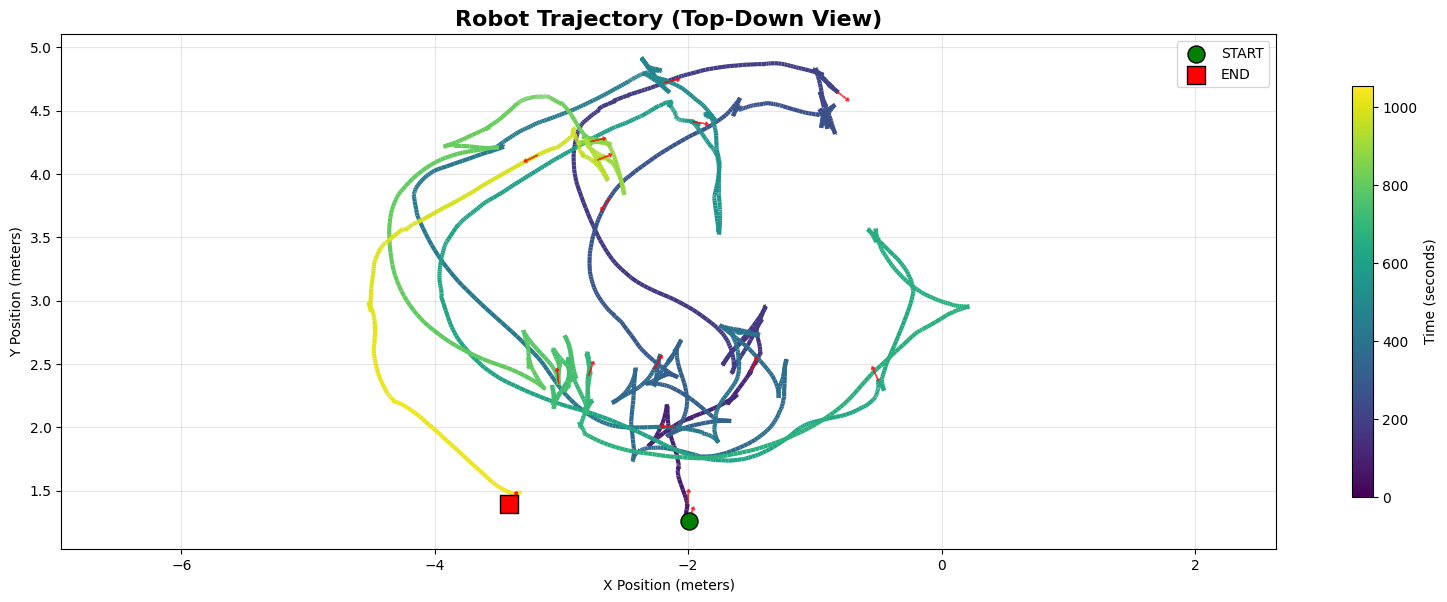

In [42]:
# Visualize trajectory
if 'df' in locals() and not df.empty:
    
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1])
    
    # 1. Main 2D trajectory plot
    ax1 = fig.add_subplot(gs[0, :])
    
    # Plot trajectory with time-based color gradient
    points = np.array([df['x'], df['y']]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    from matplotlib.collections import LineCollection
    lc = LineCollection(segments, cmap='viridis', linewidths=3)
    lc.set_array(df['time_rel'])
    line = ax1.add_collection(lc)
    
    # Mark start and end
    ax1.scatter(df['x'].iloc[0], df['y'].iloc[0], 
               color='green', s=150, marker='o', label='START', zorder=10, edgecolor='black')
    ax1.scatter(df['x'].iloc[-1], df['y'].iloc[-1], 
               color='red', s=150, marker='s', label='END', zorder=10, edgecolor='black')
    
    # Add orientation arrows
    N = max(1, len(df) // 15)
    for i in range(0, len(df), N):
        robot_x = df['x'].iloc[i]
        robot_y = df['y'].iloc[i]
        robot_yaw = df['yaw'].iloc[i]
        
        arrow_length = 0.1
        dx = arrow_length * np.cos(robot_yaw)
        dy = arrow_length * np.sin(robot_yaw)
        
        ax1.arrow(robot_x, robot_y, dx, dy, 
                 head_width=0.03, head_length=0.02, 
                 fc='red', ec='red', alpha=0.7, zorder=5)
    
    ax1.set_title('Robot Trajectory (Top-Down View)', fontsize=16, fontweight='bold')
    ax1.set_xlabel('X Position (meters)')
    ax1.set_ylabel('Y Position (meters)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.axis('equal')
    
    # Colorbar
    cbar = plt.colorbar(line, ax=ax1, shrink=0.8)
    cbar.set_label('Time (seconds)', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No trajectory data to visualize")

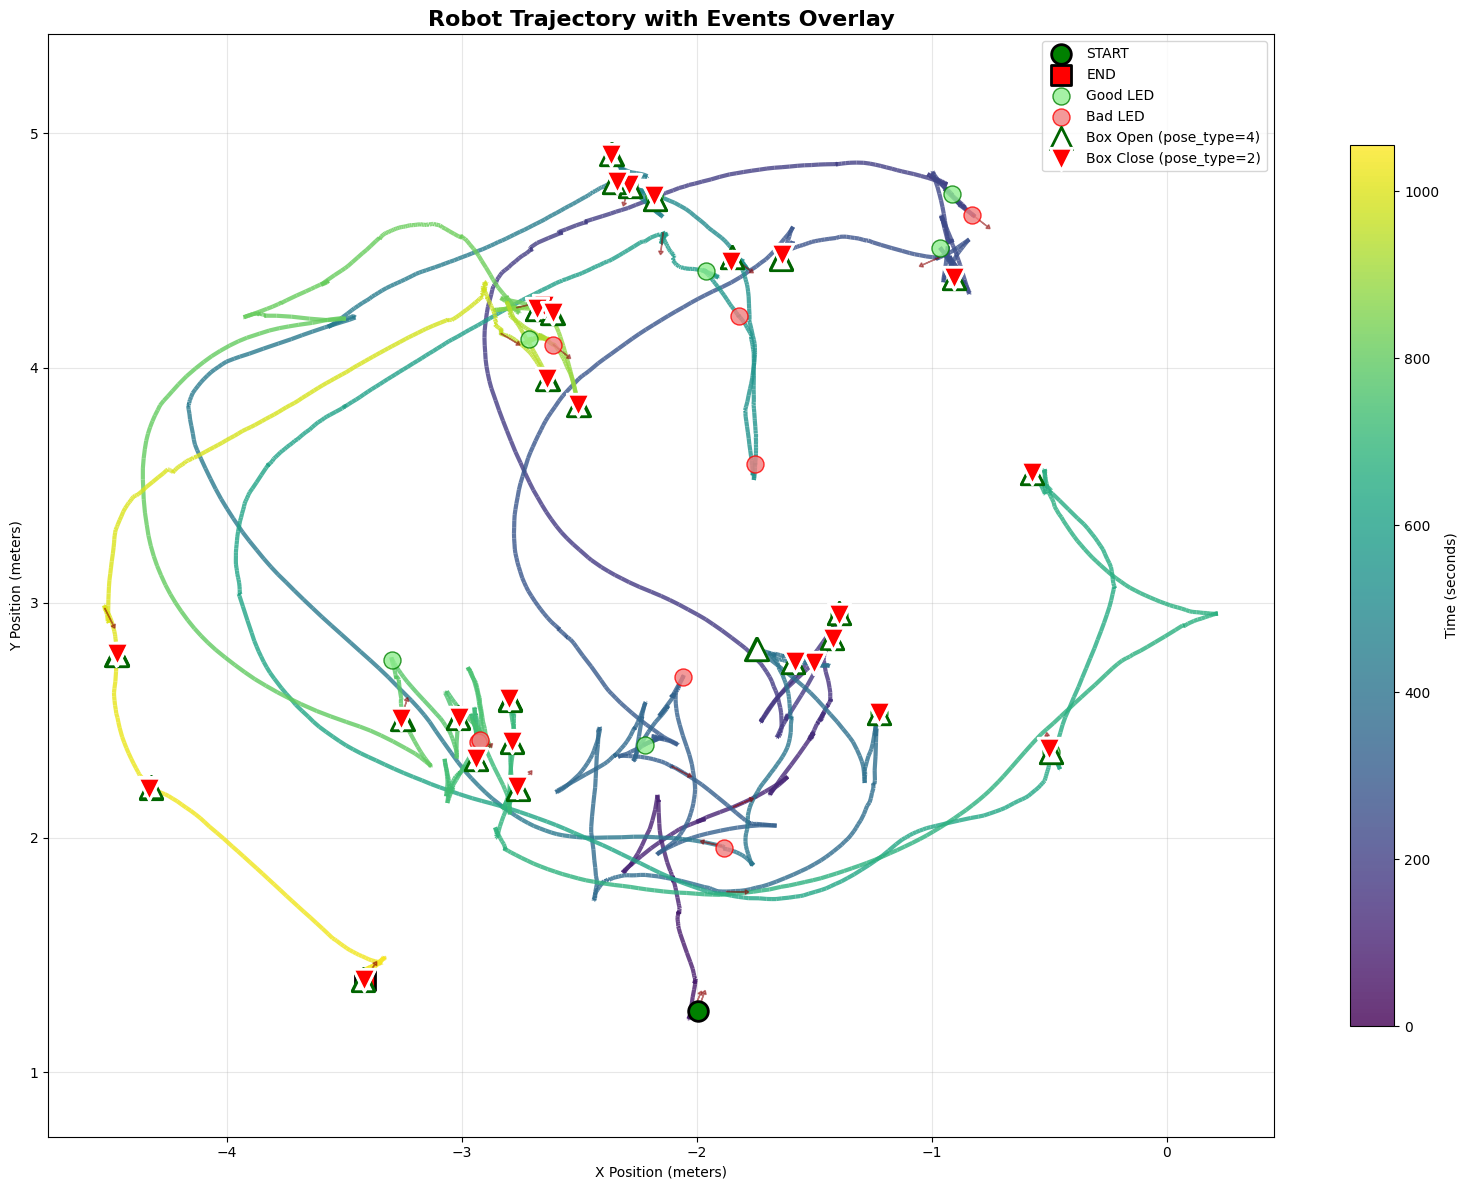

In [43]:
# Enhanced trajectory visualization with events (now includes clearer box open/close markers)
if 'df' in locals() and not df.empty:
    
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Main 2D trajectory plot with events
    ax1 = fig.add_subplot(111)
    
    # Plot trajectory with time-based color gradient
    points = np.array([df['x'], df['y']]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    from matplotlib.collections import LineCollection
    lc = LineCollection(segments, cmap='viridis', linewidths=3, alpha=0.8)
    lc.set_array(df['time_rel'])
    line = ax1.add_collection(lc)
    
    # Mark start and end
    ax1.scatter(df['x'].iloc[0], df['y'].iloc[0], 
               color='green', s=200, marker='o', label='START', zorder=10, 
               edgecolor='black', linewidth=2)
    ax1.scatter(df['x'].iloc[-1], df['y'].iloc[-1], 
               color='red', s=200, marker='s', label='END', zorder=10, 
               edgecolor='black', linewidth=2)
    
    # Add event markers
    if 'event_positions' in locals() and not event_positions.empty:
        
        # Positive feedback events
        positive = event_positions[event_positions['action'] == 'positive_feedback']
        if len(positive) > 0:
            ax1.scatter(positive['x'], positive['y'], 
                       color='gold', s=300, marker='*', label='Positive Feedback', 
                       zorder=15, edgecolor='orange', linewidth=2, alpha=0.9)
        
        # LED feedback events
        led_feedback = event_positions[event_positions['action'] == 'feedback_blink']
        if len(led_feedback) > 0:
            # Separate good vs bad feedback
            good_led = led_feedback[led_feedback['details'].astype(str).str.contains('good')]
            bad_led = led_feedback[led_feedback['details'].astype(str).str.contains('bad')]
            
            if len(good_led) > 0:
                ax1.scatter(good_led['x'], good_led['y'], 
                           color='lightgreen', s=150, marker='o', label='Good LED', 
                           zorder=12, edgecolor='green', linewidth=1, alpha=0.8)
            if len(bad_led) > 0:
                ax1.scatter(bad_led['x'], bad_led['y'], 
                           color='lightcoral', s=150, marker='o', label='Bad LED', 
                           zorder=12, edgecolor='red', linewidth=1, alpha=0.8)
        
        # Sound events
        sounds = event_positions[event_positions['event_type'] == 'sound_control']
        if len(sounds) > 0:
            ax1.scatter(sounds['x'], sounds['y'], 
                       color='mediumpurple', s=80, marker='D', label='Sounds', 
                       zorder=11, edgecolor='purple', linewidth=1, alpha=0.6)

        # Collect box open / close scatter coords (pose_type 4=open, 2=close)
        open_xs = []
        open_ys = []
        close_xs = []
        close_ys = []
        if 'open_box_events' in locals() and len(open_box_events) > 0:
            for _, ev in open_box_events.iterrows():
                diffs = np.abs(event_positions['event_time'] - (ev['time_rel'] if 'time_rel' in ev else (ev['timestamp'] - df['timestamp'].iloc[0])))
                if len(diffs):
                    idx = diffs.idxmin()
                    if diffs.loc[idx] < 0.5:
                        open_xs.append(event_positions.loc[idx, 'x'])
                        open_ys.append(event_positions.loc[idx, 'y'])
        if 'close_box_events' in locals() and len(close_box_events) > 0:
            for _, ev in close_box_events.iterrows():
                diffs = np.abs(event_positions['event_time'] - (ev['time_rel'] if 'time_rel' in ev else (ev['timestamp'] - df['timestamp'].iloc[0])))
                if len(diffs):
                    idx = diffs.idxmin()
                    if diffs.loc[idx] < 0.5:
                        close_xs.append(event_positions.loc[idx, 'x'])
                        close_ys.append(event_positions.loc[idx, 'y'])
        # Plot once for clarity
        if open_xs:
            ax1.scatter(open_xs, open_ys, marker='^', s=260, c='white', edgecolor='darkgreen', linewidth=2,
                        label='Box Open (pose_type=4)', zorder=16)
        if close_xs:
            ax1.scatter(close_xs, close_ys, marker='v', s=260, c='red', edgecolor='white', linewidth=2,
                        label='Box Close (pose_type=2)', zorder=16)
    
    # Add orientation arrows (fewer to avoid clutter)
    N = max(1, len(df) // 20)
    for i in range(0, len(df), N):
        robot_x = df['x'].iloc[i]
        robot_y = df['y'].iloc[i]
        robot_yaw = df['yaw'].iloc[i]
        
        arrow_length = 0.08
        dx = arrow_length * np.cos(robot_yaw)
        dy = arrow_length * np.sin(robot_yaw)
        
        ax1.arrow(robot_x, robot_y, dx, dy, 
                 head_width=0.02, head_length=0.015, 
                 fc='darkred', ec='darkred', alpha=0.5, zorder=5)
    
    ax1.set_title('Robot Trajectory with Events Overlay', fontsize=16, fontweight='bold')
    ax1.set_xlabel('X Position (meters)')
    ax1.set_ylabel('Y Position (meters)')
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    
    # Legend inside the plot (like in the reference code)
    ax1.legend()
    
    # Colorbar for trajectory time
    cbar = plt.colorbar(line, ax=ax1, shrink=0.8)
    cbar.set_label('Time (seconds)', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No trajectory data to visualize")

In [44]:
# Interactive trajectory visualization with a SIMPLE dual-handle time slider
# Shows GOOD/BAD feedback + BOX OPEN/CLOSE events with clearer symbols.
# Added precision controls: step size dropdown + manual start/end inputs.
# Slider width increased for finer control.

try:
    import plotly.graph_objects as go
    import numpy as np
    import pandas as pd
    from ipywidgets import (
        FloatRangeSlider, VBox, HTML, HBox, Button, Layout, Dropdown, FloatText, Label
    )
    from IPython.display import display
    import pytz
    import tzlocal
    PLOTLY_OK = True
except ImportError as e:
    print("Required libraries missing.")
    print("Install with: pip install plotly ipywidgets pytz tzlocal")
    PLOTLY_OK = False


def create_time_range_slider_widget(df, event_positions=None, max_points=15000):
    """Return a VBox containing a FigureWidget and a dual-handle time range slider with precision controls.

    Event display policy:
      - Feedback: positive, negative/bad, feedback_blink with good/bad
      - Box open (pose_type=4) and box close (pose_type=2)
    Precision controls:
      - Step size dropdown (1.0, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01)
      - Manual start/end FloatText boxes (auto-snap within bounds)
    """
    if df.empty:
        return HTML("<b>No data</b>")

    if len(df) > max_points:
        step = int(np.ceil(len(df) / max_points))
        base_df = df.iloc[::step].copy()
        print(f"⚡ Downsampled from {len(df)} to {len(base_df)} points for interaction speed")
    else:
        base_df = df.copy()

    time_rel = base_df['time_rel'].to_numpy()
    speed = base_df['speed'].to_numpy()
    x_vals = base_df['x'].to_numpy()
    y_vals = base_df['y'].to_numpy()
    yaw_deg_vals = base_df['yaw_deg'].to_numpy()
    timestamp_vals = base_df['timestamp'].to_numpy()
    local_tz = tzlocal.get_localzone()
    time_dt = pd.to_datetime(timestamp_vals, unit='s').tz_localize('UTC').tz_convert(local_tz)

    fig = go.FigureWidget(layout=dict(
        width=1200,
        height=800,
        title=dict(text='🤖 Robot Trajectory (Time-Windowed)', x=0.5, font=dict(size=22)),
        plot_bgcolor='white',
        paper_bgcolor='white',
        margin=dict(l=60, r=40, t=90, b=60),
        xaxis=dict(title='X (m)', tickfont=dict(size=12), showgrid=True, gridcolor='lightgray'),
        yaxis=dict(title='Y (m)', tickfont=dict(size=12), showgrid=True, gridcolor='lightgray', scaleanchor='x', scaleratio=1),
        hovermode='closest'
    ))

    full_path = go.Scatter(
        x=x_vals, y=y_vals, mode='lines',
        line=dict(color='rgba(150,150,150,0.30)', width=3),
        name='Full Path', hoverinfo='skip'
    )

    colored_segment = go.Scatter(
        x=x_vals, y=y_vals, mode='lines+markers',
        line=dict(color='rgba(40,90,160,0.85)', width=4),
        marker=dict(
            size=7,
            color=speed,
            colorscale='Plasma',
            showscale=True,
            colorbar=dict(title='Speed (m/s)', len=0.55)
        ),
        customdata=np.column_stack((time_rel, yaw_deg_vals)),
        hovertemplate=(
            't: %{customdata[0]:.2f}s<br>'
            'X: %{x:.2f} m<br>'
            'Y: %{y:.2f} m<br>'
            'Speed: %{marker.color:.3f} m/s<br>'
            'Heading: %{customdata[1]:.0f}°<extra></extra>'
        ),
        name='Selected Window'
    )

    start_marker = go.Scatter(
        x=[df['x'].iloc[0]], y=[df['y'].iloc[0]],
        mode='markers',
        marker=dict(size=16, color='lime', line=dict(width=3, color='darkgreen')),
        name='Start')
    end_marker = go.Scatter(
        x=[df['x'].iloc[-1]], y=[df['y'].iloc[-1]],
        mode='markers',
        marker=dict(size=16, color='red', symbol='square', line=dict(width=3, color='darkred')),
        name='End')

    good_times = bad_times = open_times = close_times = None
    good_x = good_y = bad_x = bad_y = open_x = open_y = close_x = close_y = np.array([])

    if event_positions is not None and not event_positions.empty:
        ev = event_positions.copy()
        ev['action_str'] = ev['action'].astype(str).str.lower()
        details_str = ev.get('details', pd.Series([{}]*len(ev))).astype(str).str.lower()

        good_mask = (
            (ev['action_str'] == 'positive_feedback') |
            ((ev['action_str'] == 'feedback_blink') & details_str.str.contains('good'))
        )
        bad_mask = (
            ev['action_str'].str.contains('negative|bad') |
            ((ev['action_str'] == 'feedback_blink') & details_str.str.contains('bad'))
        )

        global open_box_events, close_box_events
        if 'open_box_events' in globals() and len(open_box_events) > 0:
            open_times = open_box_events['time_rel'].to_numpy(dtype=float) if 'time_rel' in open_box_events.columns else (open_box_events['timestamp'] - df['timestamp'].iloc[0]).to_numpy(dtype=float)
        if 'close_box_events' in globals() and len(close_box_events) > 0:
            close_times = close_box_events['time_rel'].to_numpy(dtype=float) if 'time_rel' in close_box_events.columns else (close_box_events['timestamp'] - df['timestamp'].iloc[0]).to_numpy(dtype=float)

        def map_box_positions(box_times):
            if box_times is None:
                return np.array([]), np.array([])
            xs = []
            ys = []
            for bt in box_times:
                diffs = np.abs(ev['event_time'] - bt)
                if len(diffs):
                    idx = diffs.idxmin()
                    if diffs.loc[idx] < 0.6:
                        xs.append(ev.loc[idx, 'x'])
                        ys.append(ev.loc[idx, 'y'])
            return np.array(xs), np.array(ys)

        if good_mask.any():
            good_subset = ev[good_mask]
            good_times = good_subset['event_time'].to_numpy(dtype=float)
            good_x = good_subset['x'].to_numpy()
            good_y = good_subset['y'].to_numpy()
        if bad_mask.any():
            bad_subset = ev[bad_mask]
            bad_times = bad_subset['event_time'].to_numpy(dtype=float)
            bad_x = bad_subset['x'].to_numpy()
            bad_y = bad_subset['y'].to_numpy()

        open_x, open_y = map_box_positions(open_times)
        close_x, close_y = map_box_positions(close_times)

    good_trace = go.Scatter(
        x=[], y=[], mode='markers',
        marker=dict(size=14, color='gold', symbol='star', line=dict(width=2, color='orange')),
        name='Good Feedback')
    bad_trace = go.Scatter(
        x=[], y=[], mode='markers',
        marker=dict(size=12, color='lightcoral', symbol='x', line=dict(width=2, color='red')),
        name='Bad / Negative')
    open_trace = go.Scatter(
        x=[], y=[], mode='markers',
        marker=dict(size=20, color='white', symbol='triangle-up', line=dict(width=3, color='darkgreen')),
        name='Box Open')
    close_trace = go.Scatter(
        x=[], y=[], mode='markers',
        marker=dict(size=20, color='darkred', symbol='triangle-down', line=dict(width=2, color='white')),
        name='Box Close')

    fig.add_traces([full_path, colored_segment, start_marker, end_marker, good_trace, bad_trace, open_trace, close_trace])

    segment_trace = fig.data[1]
    good_trace_fig = fig.data[4]
    bad_trace_fig = fig.data[5]
    open_trace_fig = fig.data[6]
    close_trace_fig = fig.data[7]

    t_min = float(time_rel.min())
    t_max = float(time_rel.max())

    # Precision controls
    step_selector = Dropdown(
        options=[('1.0 s','1.0'), ('0.5 s','0.5'), ('0.2 s','0.2'), ('0.1 s','0.1'), ('0.05 s','0.05'), ('0.02 s','0.02'), ('0.01 s','0.01')],
        value='0.1',
        description='Step',
        layout=Layout(width='130px')
    )
    slider = FloatRangeSlider(
        value=(t_min, t_max),
        min=t_min,
        max=t_max,
        step=0.1,
        description='Time (s)',
        readout=False,
        continuous_update=True,
        layout=Layout(width='1000px')  # widened from 750px
    )
    start_input = FloatText(value=t_min, description='Start', layout=Layout(width='180px'))
    end_input = FloatText(value=t_max, description='End', layout=Layout(width='180px'))
    stats_label = HTML()
    warn_label = HTML()

    MIN_DELTA = 0.0005  # Minimum allowable span

    def clamp(v):
        return float(np.clip(v, t_min, t_max))

    def apply_inputs_to_slider():
        s0 = clamp(start_input.value)
        s1 = clamp(end_input.value)
        if s1 - s0 < MIN_DELTA:
            s1 = min(t_max, s0 + MIN_DELTA)
        slider.value = (s0, s1)

    def on_step_change(change):
        try:
            new_step = float(change['new'])
            slider.step = new_step
        except Exception:
            pass
    step_selector.observe(on_step_change, names='value')

    def on_start_change(change):
        apply_inputs_to_slider()
    def on_end_change(change):
        apply_inputs_to_slider()
    start_input.observe(on_start_change, names='value')
    end_input.observe(on_end_change, names='value')

    def update_range(_=None):
        t0, t1 = slider.value
        # sync inputs if user dragged slider
        start_input.value = t0
        end_input.value = t1
        mask = (time_rel >= t0) & (time_rel <= t1)
        if mask.any():
            segment_trace.x = x_vals[mask]
            segment_trace.y = y_vals[mask]
            segment_trace.marker.color = speed[mask]
            segment_trace.customdata = np.column_stack((time_rel[mask], yaw_deg_vals[mask]))
            dx = np.diff(x_vals[mask]); dy = np.diff(y_vals[mask])
            seg_len = np.sqrt(dx*dx + dy*dy).sum()
            abs_start = time_dt[mask][0]
            abs_end = time_dt[mask][-1]
            stats_label.value = (
                f"<span style='color:gray; font-size:14px'>"
                f"Window: {t0:.4f}s – {t1:.4f}s (Δ={(t1-t0):.4f}s) | "
                f"Absolute: {abs_start.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]} – {abs_end.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}<br>"
                f"Points: {mask.sum()} | Path length: {seg_len:.2f} m"
                f"</span>"
            )
            warn_label.value = ""
        else:
            segment_trace.x = []
            segment_trace.y = []
            segment_trace.marker.color = []
            segment_trace.customdata = []
            stats_label.value = "<span style='color:gray'>Empty selection</span>"
        if good_times is not None:
            gmask = (good_times >= t0) & (good_times <= t1)
            good_trace_fig.x = good_x[gmask] if gmask.any() else []
            good_trace_fig.y = good_y[gmask] if gmask.any() else []
        if bad_times is not None:
            bmask = (bad_times >= t0) & (bad_times <= t1)
            bad_trace_fig.x = bad_x[bmask] if bmask.any() else []
            bad_trace_fig.y = bad_y[bmask] if bmask.any() else []
        if open_times is not None:
            omask = (open_times >= t0) & (open_times <= t1)
            open_trace_fig.x = open_x[omask] if omask.any() else []
            open_trace_fig.y = open_y[omask] if omask.any() else []
        if close_times is not None:
            cmask = (close_times >= t0) & (close_times <= t1)
            close_trace_fig.x = close_x[cmask] if cmask.any() else []
            close_trace_fig.y = close_y[cmask] if cmask.any() else []

    slider.observe(update_range, names='value')
    update_range()

    reset_btn = Button(description='Reset', layout=Layout(width='70px'))
    def do_reset(_):
        slider.value = (t_min, t_max)
        step_selector.value = '0.1'
        slider.step = 0.1
    reset_btn.on_click(do_reset)

    header = HTML("<b style='font-size:15px'>Select time window — Feedback + Box Open (▲) / Close (▼).<br>Use Step dropdown or manual Start/End for fine precision (4 decimal places shown).</b>")

    controls_row1 = HBox([slider])
    controls_row2 = HBox([step_selector, reset_btn, start_input, end_input])
    return VBox([header, controls_row1, controls_row2, stats_label, warn_label, fig])


if PLOTLY_OK and 'df' in locals() and not df.empty:
    print("Building interactive range slider visualization (feedback + box events) with precision controls ...")
    try:
        widget = create_time_range_slider_widget(df, event_positions if 'event_positions' in locals() else None)
        display(widget)
        print("Ready. Adjust the slider or use Start/End boxes for precise selection.")
    except Exception as e:
        print(f"Failed to build widget: {e}")
        print("If ipywidgets is not enabled, run: pip install plotly ipywidgets pytz tzlocal")
else:
    if not PLOTLY_OK:
        print("Plotly/ipywidgets unavailable.")
    else:
        print("No trajectory data available for interactive visualization")

Building interactive range slider visualization (feedback + box events) with precision controls ...


Ready. Adjust the slider or use Start/End boxes for precise selection.
